In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
import torch.optim as optim
import random
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

from sklearn.manifold import TSNE
import seaborn as sn
import  pandas as pd

classes=[str(i) for i in range(0,10)]


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Data & Preprocessing

Random seeds:

In [2]:
torch.manual_seed(1)
random.seed(1)
np.random.seed(1)

Datasets + Dataloaders for MNIST:

In [3]:
shuf = False
batch_size = 64
lrn_rate=0.001

##    ALL DATASET

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                ])

dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=shuf, num_workers=2)

valloader=torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=shuf, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=shuf, num_workers=2)

dataset+dataloader for the OSR Set - 500 examples from CIFAR10 (grayscale, resized to 28*28):

In [4]:
OOD_transform = transforms.Compose([T.ToTensor(),
                                    T.Normalize((0.5,), (0.5,)),
                                    T.Grayscale(num_output_channels=1),
                                    T.Resize(28)
                                    ])

OOD_testset = torchvision.datasets.CIFAR10(root='./test', train=False,
                                           download=True, transform=OOD_transform)

OOD_testset, _ = torch.utils.data.random_split(OOD_testset, [500, len(OOD_testset.data.data) - 500])

OOD_testloader = torch.utils.data.DataLoader(OOD_testset, batch_size=500,
                                             shuffle=shuf, num_workers=2)

Files already downloaded and verified


Let's view some of the samples in MNIST:

tensor([[7, 0, 7, 2, 0, 1, 5, 0, 1, 2],
        [3, 5, 3, 9, 1, 4, 4, 2, 4, 9],
        [0, 8, 4, 1, 0, 2, 5, 6, 5, 2],
        [4, 6, 4, 7, 6, 5, 0, 5, 2, 6],
        [9, 6, 3, 2, 4, 8, 2, 2, 9, 3],
        [0, 3, 1, 0, 6, 3, 1, 3, 7, 1]])
------------------------------------------------


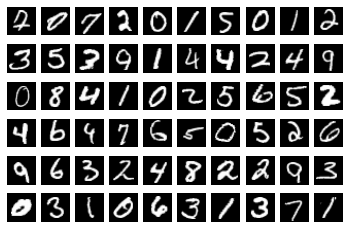

In [5]:
dataiter = iter(trainloader)

images, labels = dataiter.next()
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray')
print(labels[1:61].reshape((6, 10)))
print("------------------------------------------------")

And some of CIFAR10:

tensor([[7, 6, 5, 3, 9, 8, 4, 6, 9, 0],
        [0, 4, 0, 2, 3, 2, 0, 4, 9, 9],
        [2, 8, 0, 1, 6, 9, 4, 2, 2, 4],
        [1, 7, 6, 6, 1, 5, 9, 1, 7, 4],
        [2, 4, 7, 9, 3, 3, 2, 2, 9, 5],
        [4, 1, 3, 7, 0, 3, 5, 5, 9, 5]])
------------------------------------------------


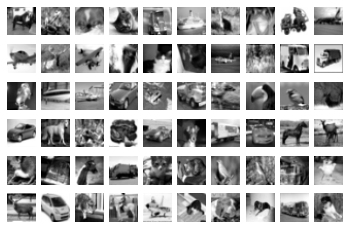

In [6]:
dataiter = iter(OOD_testloader)

images, labels = dataiter.next()
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray')
print(labels[1:61].reshape((6, 10)))
print("------------------------------------------------")

# 2. Models

## Baseline Model - CNN Archtecture
In our base model we chose to use a CNN architecure:
The input is 28*28
Layer 1: conv layer with kernel size of 5, stride of 1, padding of 1, with 8 output channels, followed by a ReLu activation.
Layer 2: max pooling layer with kernel size of 2, stride of 2 and zero padding.
Layer 3: conv layer with kernel size of 5, stride of 1, padding of 1, with 16 output channels, followed by a ReLu activation.
Layer 4: max pooling layer with kernel size of 2, stride of 2 and zero padding.
Layer 5: a fully-connected layer of 128 neurons, followed by a ReLu activation.
Layer 6: a fully-connected layer of 32 neurons , followed by a ReLu activation.
Layer 7: a fully-connected layer of 10 neurons (as the number of distinct labels).

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        W,P,S,kersize=28,2,1,5
        w = (((W - kersize + 2 * P) / S) + 1) // 2
        outwidth = int((((w - kersize + 2 * P) / S) + 1) // 2)
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=kersize, stride=S, padding=P), # Layer 1
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2),  # Layer 2

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=kersize, stride=S, padding=P), # Layer 3
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2),  # Layer 4

            nn.Flatten(),
            nn.Linear(16 * outwidth * outwidth, 128),  # Layer 5
            nn.ReLU(),
            nn.Linear(128, 32),  # Layer 6
            nn.ReLU(),
            nn.Linear(32, 10))  # Layer 7


    def forward(self, x):
        return self.model(x)

## The OSR model - Siamese network
Our network is a siamese network which is identical to the baseline model but using the paradigm of Contrastive Learning on the penuliated layer using the Contrastive-Loss function.

In [8]:
class SiameseFCNet(nn.Module):

    def __init__(self, kersize=5):
        super(SiameseFCNet, self).__init__()

        self.train_siam=True

        W,P,S=28,2,1
        w = (((W - kersize + 2 * P) / S) + 1) // 2
        self.outwidth = int((((w - kersize + 2 * P) / S) + 1) // 2)

        self.conv1=nn.Conv2d(in_channels=1, out_channels=8, kernel_size=kersize, stride=S, padding=P)# 1st convolutional layer
        self.pool1=nn.MaxPool2d(kernel_size=2)  # Pooling layer
        self.conv2=nn.Conv2d(in_channels=8, out_channels=16, kernel_size=kersize, stride=S, padding=P)# 2nd convolutional layer     
        self.pool2=nn.MaxPool2d(kernel_size=2)  # Pooling layer

        self.fc1=nn.Linear(16 * self.outwidth**2, 128)  # 1st linear(fully connected) layer
        self.fc2=nn.Linear(128, 32)  # 2nd linear(fully connected) layer
        self.fc3=nn.Linear(32, 10)  # 3rd linear(fully connected) layer

        self.dropout1=nn.Dropout(0.3)
        self.dropout2=nn.Dropout(0.3)  

    def Train_siam(self, train_siam=True):
      self.train_siam=train_siam

    def forward_one(self,x):
        z=self.conv1(x)
        z=F.relu(z)
        z=self.pool1(z)
        z=self.conv2(z)
        z=F.relu(z)
        z=self.pool2(z)

        z=z.reshape(z.size(0),-1)
        z=self.fc1(z)
        z=F.relu(z)
        z=self.fc2(z)

        #penuliated layer
        z=F.relu(z)
        z=self.fc3(z)

        return z

    def forward(self, x1,x2=None):
        o1= self.forward_one(x1)
        if self.train_siam:
            o2= self.forward_one(x2)
            return o1,o2
        
        return o1

# 3.Training

In [9]:
def plot_loss_acc(performence):         # A method for plotting the training/validtion loss and accuracy during training phase
    plt.figure(1,figsize=(16,5))
    plt.suptitle("Loss and Accuracy per epoch",fontsize=20)

    epochs=len(performence["train_acc"])+1

    plt.subplot(131)
    plt.plot(range(1,epochs),performence["train_losses"],label="Train Loss")
    plt.plot(range(1,epochs),performence["val_losses"],label="Validation Loss")
    plt.title(f'Loss')
    plt.xlabel('epoch(#)')
    plt.ylabel("loss")
    plt.legend()

    plt.subplot(132)
    plt.plot(range(1,epochs),performence["train_acc"],label="Train Accuracy(%)")
    plt.plot(range(1,epochs),performence["val_acc"],label="Validation Accuracy(%)")
    plt.title(f'Accuracy(%)')
    plt.xlabel('epoch(#)')
    plt.ylabel("accuracy(%)")
    plt.legend()


    plt.show()

In [10]:
def check_accuracy(net, loader,embed=lambda x:x):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data  # Getting the test data

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(embed(inputs))  # Getting the network output
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    percentage = 100 * correct / total
    return percentage

## Baseline Model - CNN Archtecture

In [11]:
def train_model(model, trainloader, optimizer, model_type="CNN", criterion=nn.CrossEntropyLoss(), epochs=30,embed=lambda x:x):
    train_losses = []
    train_acc = []
    val_acc = []
    val_losses = []

    for epoch in range(epochs):
        train_running_loss = 0.0
        batches = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            inputs=embed(inputs)
            outputs = model(inputs)

            l = criterion(outputs, labels)
            l.backward()
            optimizer.step()

            train_running_loss += l.item()
            batches += 1

        train_loss = train_running_loss / batches

        val_running_loss = 0.0
        batches = 0
        for i, data in enumerate(valloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(embed(inputs))
            l_val = criterion(outputs, labels)
            val_running_loss += l_val.item()
            batches += 1

        val_loss = val_running_loss / batches

        val_losses.append(val_loss)
        train_losses.append(train_loss)
        train_acc.append(check_accuracy(model, trainloader,embed=embed))
        val_acc.append(check_accuracy(model, valloader,embed=embed))

        print('epoch: %2d, loss: %.3f, train_acc: %.3f, val_acc: %.3f' % (epoch + 1, train_loss, train_acc[-1], val_acc[-1]))
    print('Finished Training')

    return {"train_losses": train_losses, "val_losses": val_losses, "train_acc": train_acc, "val_acc": val_acc}

In [12]:
CNN_model = ConvNet().to(device)
CNN_optimizer = optim.Adam(CNN_model.parameters(), lr=lrn_rate)
CNN_performence = train_model(CNN_model, trainloader, CNN_optimizer, epochs=30)

epoch:  1, loss: 0.311, train_acc: 96.698, val_acc: 96.740
epoch:  2, loss: 0.081, train_acc: 97.882, val_acc: 97.670
epoch:  3, loss: 0.057, train_acc: 98.690, val_acc: 98.350
epoch:  4, loss: 0.044, train_acc: 99.004, val_acc: 98.570
epoch:  5, loss: 0.036, train_acc: 99.192, val_acc: 98.610
epoch:  6, loss: 0.029, train_acc: 99.226, val_acc: 98.550
epoch:  7, loss: 0.024, train_acc: 99.210, val_acc: 98.390
epoch:  8, loss: 0.020, train_acc: 99.020, val_acc: 98.230
epoch:  9, loss: 0.019, train_acc: 99.080, val_acc: 98.310
epoch: 10, loss: 0.015, train_acc: 98.684, val_acc: 97.850
epoch: 11, loss: 0.013, train_acc: 99.082, val_acc: 98.300
epoch: 12, loss: 0.012, train_acc: 99.172, val_acc: 98.450
epoch: 13, loss: 0.010, train_acc: 98.936, val_acc: 97.990
epoch: 14, loss: 0.009, train_acc: 98.460, val_acc: 97.600
epoch: 15, loss: 0.010, train_acc: 99.286, val_acc: 98.150
epoch: 16, loss: 0.009, train_acc: 99.516, val_acc: 98.580
epoch: 17, loss: 0.007, train_acc: 99.672, val_acc: 98.6

In [13]:
PATH = f'./Base_CNN_model.pth'
torch.save(CNN_model.state_dict(), PATH)

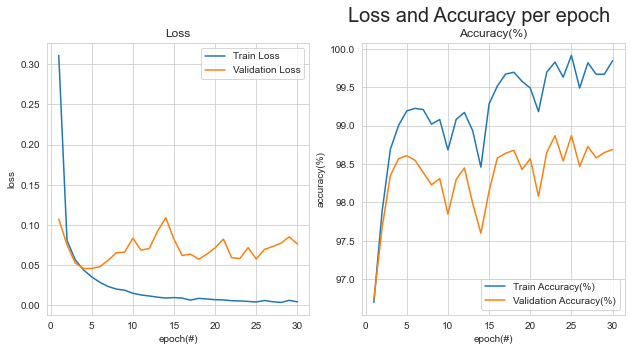

In [14]:
plot_loss_acc(CNN_performence)

### The OSR model - Siamese network

In [15]:
class ContrastiveLoss(nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin=margin

    def forward(self, output1, output2, label):
        output1 = output1.type(torch.DoubleTensor)
        output2 = output2.type(torch.DoubleTensor)
        label = label.type(torch.DoubleTensor)

        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2)+
                                        label   * torch.pow(torch.clamp(self.margin-euclidean_distance, min=0.0), 2) )

        return loss_contrastive

In a siamese network each pair is an input to the network. We want the trainings to be as similar as possible and there fore we will double the batch_size in order to get the same batch size in reality:

In [16]:
siamese_trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size*2,
                                          shuffle=shuf, num_workers=2)

siamese_valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size*2,
                                        shuffle=shuf, num_workers=2)

siamese_testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size*2,
                                         shuffle=shuf, num_workers=2)

In [17]:
def train_siamese(model, trainloader, optimizer, criterion=ContrastiveLoss(), epochs=30):
    train_losses = []
    train_acc = []
    val_acc = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_running_loss = 0.0
        batches = 0

        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            X1,X2=torch.tensor_split(inputs,2)      #128 samples tensor to a 64 tensor of pairs
            flags=torch.tensor_split(labels,2)
            flags=((flags[0]-flags[1])!=0).double()      #0 iff label(pair[0])==label(pair[1])


            O1,O2=model(X1,X2)
            optimizer.zero_grad()
            loss_contrastive = criterion(O1,O2,flags)
            tl = loss_contrastive.item()
            train_running_loss+=tl
            loss_contrastive.backward()
            optimizer.step()

            batches += 1

        train_loss = train_running_loss / batches
        train_losses.append(train_loss)

        print('epoch: %2d, loss: %.3f' % (epoch + 1, train_loss))
    print('Finished Training')

    return {"train_losses": train_losses}

#### 1st Stage - Creating a good embedding space:
As mentioned above, in each forward pass 2 samples are fed to the network and backprop is performed to minimize the Contrastive_Loss on the embedding vectors.
The embedding layer in our network is the penuliated layer of this architecture(the 10-d vector before the softmax layer which is built in to pytorch's CrossEntropyLoss function). We would like to share that we have all the 3 FC layers of our model as embedding layers but the last one showed the best results and that is why we chose it.

In [18]:
SiameseFC_model = SiameseFCNet().to(device)
Siamese_optimizer = optim.Adam(SiameseFC_model.parameters(), lr=lrn_rate)
Siamese_performence = train_siamese(SiameseFC_model, siamese_trainloader,Siamese_optimizer, epochs=40)

epoch:  1, loss: 0.306
epoch:  2, loss: 0.131
epoch:  3, loss: 0.092
epoch:  4, loss: 0.065
epoch:  5, loss: 0.048
epoch:  6, loss: 0.036
epoch:  7, loss: 0.028
epoch:  8, loss: 0.021
epoch:  9, loss: 0.016
epoch: 10, loss: 0.013
epoch: 11, loss: 0.010
epoch: 12, loss: 0.009
epoch: 13, loss: 0.008
epoch: 14, loss: 0.007
epoch: 15, loss: 0.007
epoch: 16, loss: 0.007
epoch: 17, loss: 0.005
epoch: 18, loss: 0.005
epoch: 19, loss: 0.005
epoch: 20, loss: 0.003
epoch: 21, loss: 0.004
epoch: 22, loss: 0.005
epoch: 23, loss: 0.006
epoch: 24, loss: 0.003
epoch: 25, loss: 0.002
epoch: 26, loss: 0.002
epoch: 27, loss: 0.003
epoch: 28, loss: 0.003
epoch: 29, loss: 0.002
epoch: 30, loss: 0.003
epoch: 31, loss: 0.002
epoch: 32, loss: 0.002
epoch: 33, loss: 0.005
epoch: 34, loss: 0.002
epoch: 35, loss: 0.001
epoch: 36, loss: 0.001
epoch: 37, loss: 0.001
epoch: 38, loss: 0.001
epoch: 39, loss: 0.004
epoch: 40, loss: 0.004
Finished Training


#### 2nd Stage - teaching the network to classify correctly:
In this stage we train the network in the 'normal' way: we feed 1 sample for 1 output and we minimize the Cross-Entropy loss.

In a paper by Khoslaand and Teterwak("Supervised Contrastive Learning" - google research,2020), the authors chose to freeze the learning of the parameters in the layers that are prior to the embedding layer and thus the learning is only on the parameters that follow the embedding layer.
As mentioned above we have tried different FC layers as embedding layers and in each case we have also tried to freeze the learning of the parametersof the layers before it. However, that did non benefit our ntwork and thus we have neglected the idea.

In [19]:
SiameseFC_model.Train_siam(False)
Siamese_optimizer = optim.Adam(SiameseFC_model.parameters(), lr=lrn_rate)
Siamese_performence = train_model(SiameseFC_model, siamese_trainloader,Siamese_optimizer,criterion=nn.CrossEntropyLoss(), epochs=30)

epoch:  1, loss: 0.164, train_acc: 98.884, val_acc: 98.430
epoch:  2, loss: 0.041, train_acc: 99.202, val_acc: 98.590
epoch:  3, loss: 0.029, train_acc: 99.390, val_acc: 98.710
epoch:  4, loss: 0.021, train_acc: 99.502, val_acc: 98.820
epoch:  5, loss: 0.017, train_acc: 99.568, val_acc: 98.780
epoch:  6, loss: 0.012, train_acc: 99.598, val_acc: 98.720
epoch:  7, loss: 0.010, train_acc: 99.678, val_acc: 98.780
epoch:  8, loss: 0.008, train_acc: 99.700, val_acc: 98.790
epoch:  9, loss: 0.008, train_acc: 99.678, val_acc: 98.750
epoch: 10, loss: 0.007, train_acc: 99.684, val_acc: 98.710
epoch: 11, loss: 0.006, train_acc: 99.704, val_acc: 98.850
epoch: 12, loss: 0.005, train_acc: 99.734, val_acc: 98.820
epoch: 13, loss: 0.004, train_acc: 99.730, val_acc: 98.730
epoch: 14, loss: 0.004, train_acc: 99.878, val_acc: 99.010
epoch: 15, loss: 0.006, train_acc: 99.894, val_acc: 98.820
epoch: 16, loss: 0.002, train_acc: 99.918, val_acc: 98.930
epoch: 17, loss: 0.005, train_acc: 99.854, val_acc: 98.9

In [20]:
PATH = f'./Siamese_model.pth'
torch.save(SiameseFC_model.state_dict(), PATH)

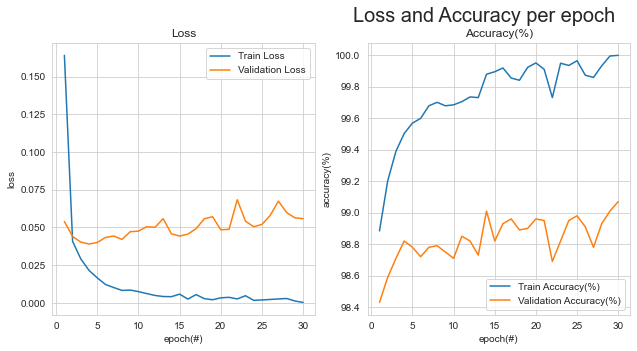

In [21]:
plot_loss_acc(Siamese_performence)

# 4. Evaluation

In [22]:
def pred(net, loader,embed=lambda x:x):
    y_true=[]
    y_pred=[]
    with torch.no_grad():
        for data in loader:
            inputs, labels = data  # Getting the test data

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(embed(inputs))  # Getting the network output
            _, predicted = torch.max(outputs.data, 1)
            y_pred+=predicted
            y_true+=labels

    y_pred=[int(y) for y in y_pred]
    y_true=[int(y.cpu()) for y in y_true]
    return y_pred, y_true

## Baseline Model - CNN Archtecture

In [23]:
print(f"The accuracy for the base model with on Test Set: {format(check_accuracy(CNN_model,testloader),'.3f')}%")

The accuracy for the base model with on Test Set: 98.810%


Confusion Matrix:

<AxesSubplot:>

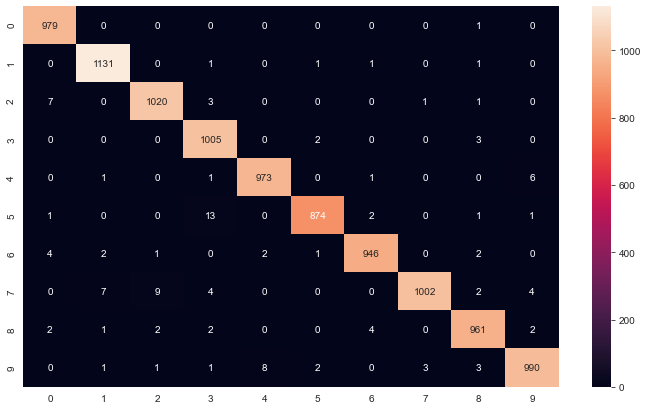

In [24]:
y_pred, y_true=pred(CNN_model,testloader)
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True,fmt='g')

## The rationale for the use of Contrastive Learning(Siamese networks):

In the OSR setting, we can't know what to expect and the best we can do is to manipulate our data(MNIST in this case) in a way that will hopefully yield a good distinguish between data from our distribution of interst and the rest of it(the open space).
Many of the known algorithms for the OSR problem try to embed the data in some way and then work on these embeddings. A reasonable requirement for such embedding could be that in the embedding space, samples with the same label would be close to each other and samples of different classes will be far. That basic logic led us to use a paradigm called "Contrastive Learning".

Our model implies Contrastive Learning using a Siamese network architecure.
The Siamese network was first introduced in the 1990s by LeCun and could be described as follows:
2 identical networks that uses the same weights while working in tandem on two different inputs (x1, x2) to compute an embedding vector for each of them(v1, v2). These embeddings are then fed to the Constrative-Loss function along with a flag that indicates rather these inputs share the same label or not(0 if l1=l2 and 1 otherwise). The Contrastive-Loss penalize the network according to the distance between v1 and v2 and the flag.
Technically we use the same network 2 times one after the other and the output is a tuple of embedding vectors.

In the first phase we train our model on pairs of samples and with the Contrastive-Loss function to get the samples group according to their label.
In the second phase we train the network normally using the Cross-Entropy-Loss function and with one sample at each forward pass.

To distinguish between OOD data and data that is from the distribution we have tried few methods for anomaly detection such as One-Class SVM and Isolation-Forest. However, we will use uncertainty threshohold for the softmax layers as it was the best performing method we tried. The literature states that this is usually not enough but, we believe that our pre-training on the siamese network benefited the robustness of this method.
It is worth mentioning that the usage of Contrastive Learning for the OSR problem is something that was already examined. For example in the
paper "Open-set Recognition with Supervised Contrastive Learning"(2021, https://ieeexplore.ieee.org/document/9511382) by Kodama. In his paper he used the same methodology of first training the network to find a good embedding space but then they used an OpenMax layer in similar to Bendale & Boult(2016).

Note: The architecture of the network is identical to the baseline architecture we have introduced before. The only difference is the additional training on the penulimate layer with the Contrastive-Loss to create a contrastive learning.

You can hear more about the topic in this podcast:
https://explainable.podbean.com/e/למידה-ניגודית-contrastive-learning/
The idea for using contrastive learning was given in a following episode:
https://explainable.podbean.com/e/novel-class-discovery-זיו-פרוינד-על/

## OOD Results


In [25]:
SiameseFC_model.eval()
outputs_mnist=SiameseFC_model.forward_one(testset.data[:,None,:,:].float().to(device))
X_test_mnist = np.asarray(outputs_mnist.detach().cpu())
X_test_mnist=X_test_mnist.reshape(X_test_mnist.shape[0], -1)

outputs_ood=[]
for i, data in enumerate(OOD_testloader, 0):
  inputs, labels = data
  inputs, labels = inputs.to(device), labels.to(device)
  outputs_ood = SiameseFC_model(inputs)

In [26]:
thr=0.999    #threshold on softmax "probabilities"
y_pred_mnist=(F.softmax(outputs_mnist).max(1)[0]>thr).int().cpu().numpy()
y_pred_ood=(F.softmax(outputs_ood).max(1)[0]>thr).int().cpu().numpy()

/var/folders/lj/hr6qchrn00z92hn3p2g6cy7m0000gn/T/ipykernel_61799/3300981820.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred_mnist=(F.softmax(outputs_mnist).max(1)[0]>thr).int().cpu().numpy()
/var/folders/lj/hr6qchrn00z92hn3p2g6cy7m0000gn/T/ipykernel_61799/3300981820.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred_ood=(F.softmax(outputs_ood).max(1)[0]>thr).int().cpu().numpy()


<AxesSubplot:>

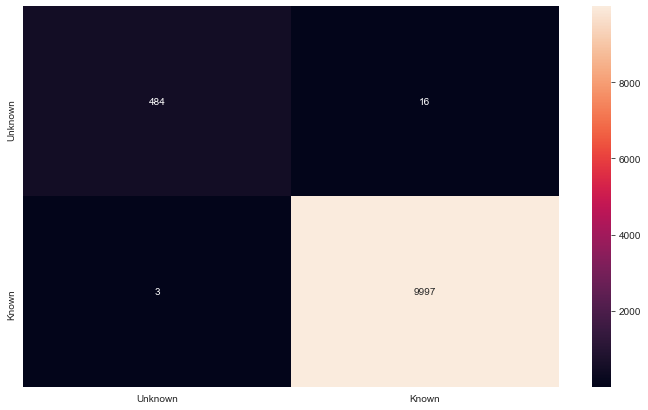

In [27]:
y_pred=np.append(y_pred_mnist,y_pred_ood)
y_true= np.append(np.ones_like(y_pred_mnist), np.zeros_like(y_pred_ood))
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in ['Unknown','Known']],
                     columns = [i for i in ['Unknown','Known']])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True,fmt='g')

We think this result is pretty impresive. In 9,992/10,000 samples from the MNIST test set, our model is at least 99.9% confident that these are indeed samples from the same distribution as MNIST digits.

P.S: The threshold was chosen based on a survey of the results + gridsearch

## OSR Results


First of all let's see the accuracy of the new architecture on the closed set of mnist(same test as we did for the CNN architecture):

In [28]:
print(f"The accuracy for the Siamese FC model with Test Set: {format(check_accuracy(SiameseFC_model,testloader),'.3f')}%")

The accuracy for the Siamese FC model with Test Set: 99.090%


In [29]:
def predict(net, dataloader):
  out=[]
  lbls=[]
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs = inputs.to(device)

      outputs = net(inputs)
      out.append(outputs)
      lbls.append(labels)
      
  out = torch.cat(out, 0)
  lbls=torch.cat(lbls, 0)
  return out,lbls

def convert_to_classes(output):
  ood_pred=(F.softmax(output).max(1)[0]>0.99).int()
  mnist_pred=F.softmax(output).max(1)[1]
  pred=[]
  for i,j in zip(ood_pred,mnist_pred):
    if i==0:
      pred.append(10)
    else:
      pred.append(int(j))
  return pred


In [30]:
output_mnist,labels_mnist=predict(SiameseFC_model,testloader)
output_ood,_=predict(SiameseFC_model,OOD_testloader)
y_pred_mnist=convert_to_classes(output_mnist)
y_pred_ood=convert_to_classes(output_ood)

y_pred=np.append(y_pred_mnist,y_pred_ood)
y_true= np.append(labels_mnist, np.ones_like(y_pred_ood)*10)

/var/folders/lj/hr6qchrn00z92hn3p2g6cy7m0000gn/T/ipykernel_61799/4237673702.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_pred=(F.softmax(output).max(1)[0]>0.99).int()
/var/folders/lj/hr6qchrn00z92hn3p2g6cy7m0000gn/T/ipykernel_61799/4237673702.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mnist_pred=F.softmax(output).max(1)[1]


Accuracy:

In [34]:
print(f"The accuracy for the Siamese FC model with closed and open set data: {format((y_pred==y_true).sum()*100/y_true.shape[0],'.3f')}%")

The accuracy for the Siamese FC model with closed and open set data: 97.752%


Confusion Matrix for the 11 classes:

<AxesSubplot:>

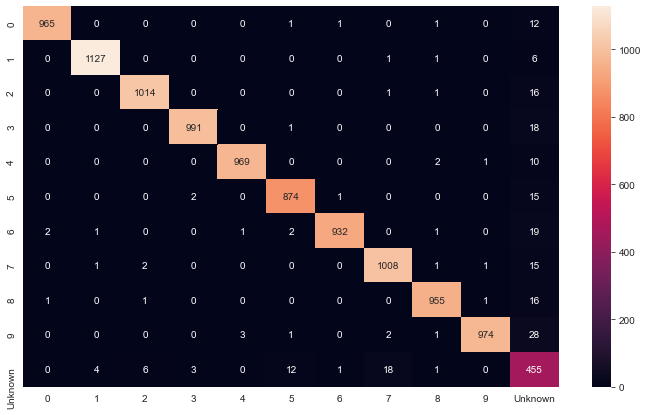

In [35]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes+['Unknown']],
                     columns = [i for i in classes+['Unknown']])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True,fmt='g')

It is hard to say how our model will perform on other data since the space of possibilities is infinite. However, it is likely to think that the performence will be somewhat similiar to what we have achieved here on images from the real world.
Images of other charachters(Optical Character Recognition) might be a bit more difficult as they share common properties.
Overall we think we have achieved some good results thus it is likely that the results on other sets will be pretty good as well.

## t-SNE drawings
Unfortunatley we w
ere out of GPU and on our laptops it took forever. If you decide to train on a GPU it will be pretty fast.

All 11 classes

In [ ]:
output_all= torch.cat([output_mnist,output_ood], 0)
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(output_all)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train,s=5)
plt.show()